In [1]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_swiss_roll, make_s_curve
from scipy.sparse import csr_matrix, spdiags
from sklearn.utils.graph import graph_laplacian
from scipy.sparse.linalg import eigsh

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
plt.style.use('ggplot')

%matplotlib inline

This notebook will walk through the steps of Laplacian Eigenmaps (LE) algorithm. It will be a step-by-step walkthrough of the algorithm and towards the notebook, I will work on some common known speed-up attempts.

In [156]:
seed = 123
rng = np.random.seed(123)
n_samples = 1500
noise = 0.1
random_state = seed

data, color = make_swiss_roll(n_samples=n_samples, noise=noise, random_state=random_state)
data, color = make_s_curve(n_samples=n_samples, noise=noise, random_state=random_state)

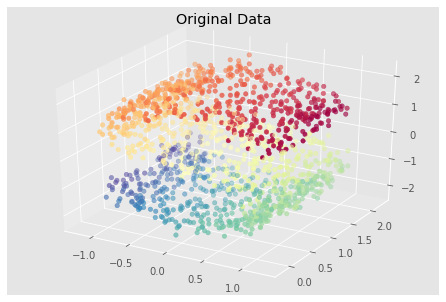

In [157]:
fig = plt.figure()

ax = p3.Axes3D(fig)

ax.scatter(data[:,0], data[:, 1], data[:,2], c=color, cmap=plt.cm.Spectral)
ax.set_title("Original Data")
plt.show()

## Kernel Matrix Construction

In [158]:
# some baseline parameters
n_neighbors = 10
algorithm = 'brute'
metric = 'euclidean'
p=2
n_jobs = -1

# initialize nn model
nn_model = NearestNeighbors(
    n_neighbors=n_neighbors,
    metric=metric,
    algorithm=algorithm,
    p=p,
    n_jobs=n_jobs
)

# fit nn model to data
nn_model.fit(data);

# grab distances and indices
dists, indices = nn_model.kneighbors(
    data, 
    n_neighbors=n_neighbors, 
    return_distance=True
)

In [159]:
# Heat kernel
def heat_kernel(distances, gamma=None):
    if gamma is None:
        gamma = 1.0 / distances.shape[1]
    return np.exp(- gamma * distances**2)

In [160]:
from scipy.sparse.csgraph import laplacian as sci_laplacian

In [237]:
# # transform distances with heat kernel
# dists = heat_kernel(dists)

affinity_matrix = nn_model.kneighbors_graph(
    X=data,
    n_neighbors=n_neighbors,
    mode='distance')

# Make the matrix symmetric
affinity_matrix = 0.5 * (affinity_matrix + affinity_matrix.T)

# # Apply the Heat Kernel
gamma = 1.0 / affinity_matrix.shape[0]
affinity_matrix.data = np.exp(- gamma * affinity_matrix.data**2)

L, degree = sci_laplacian(affinity_matrix, normed=True, return_diag=True)

In [212]:
print(L.shape, degree.shape)

(1500, 1500) (1500,)


In [213]:
from sklearn.metrics.pairwise import rbf_kernel

In [214]:
# RBF Kernel
K = rbf_kernel(data, gamma=1.0)



# Degree Matrix 
degree = K.sum(axis=1)
L = np.diag(degree) - K

In [ ]:
affinity_matrix = nb

## EigenValue Decomposition

### Graph Embedding

In [238]:
from sklearn.utils.extmath import _deterministic_vector_sign_flip

In [239]:
%%time

# Transform equation
lap_sol = -1 * L

n_components = 2
solver = 'LM'      # Smallest to Largest
sigma = 1.0
eigen_tol = 0.0
v0 = np.random.uniform(-1, 1, lap_sol.shape[0])

eigenvalues, eigenvectors = eigsh(
    lap_sol,
    k=n_components+1,
    which=solver,
    sigma=sigma,
    tol=eigen_tol,
    v0=v0
)

# Transform eigenvectors
embedding = eigenvectors.T[(n_components+1)::-1]

# Deterministic sign flip
embedding = _deterministic_vector_sign_flip(embedding)

embedding = embedding[1:n_components+1].T

CPU times: user 194 ms, sys: 4.9 ms, total: 199 ms
Wall time: 112 ms


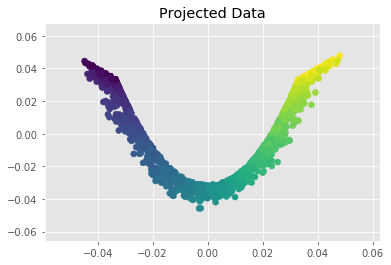

In [240]:
fig, ax = plt.subplots()

ax.scatter(embedding[:, 0], embedding[:, 1], c=color)
ax.set_title('Projected Data')
plt.show()

### Linear Graph Embedding

In [241]:
from scipy.linalg import eigh

In [206]:
def eigh_robust(a, b=None, eigvals=None, eigvals_only=False,
                overwrite_a=False, overwrite_b=False,
                turbo=True, check_finite=True):
    """Robustly solve the Hermitian generalized eigenvalue problem
    This function robustly solves the Hermetian generalized eigenvalue problem
    ``A v = lambda B v`` in the case that B is not strictly positive definite.
    When B is strictly positive-definite, the result is equivalent to
    scipy.linalg.eigh() within floating-point accuracy.
    Parameters
    ----------
    a : (M, M) array_like
        A complex Hermitian or real symmetric matrix whose eigenvalues and
        eigenvectors will be computed.
    b : (M, M) array_like, optional
        A complex Hermitian or real symmetric matrix.
        If omitted, identity matrix is assumed.
    eigvals : tuple (lo, hi), optional
        Indexes of the smallest and largest (in ascending order) eigenvalues
        and corresponding eigenvectors to be returned: 0 <= lo <= hi <= M-1.
        If omitted, all eigenvalues and eigenvectors are returned.
    eigvals_only : bool, optional
        Whether to calculate only eigenvalues and no eigenvectors.
        (Default: both are calculated)
    turbo : bool, optional
        Use divide and conquer algorithm (faster but expensive in memory,
        only for generalized eigenvalue problem and if eigvals=None)
    overwrite_a : bool, optional
        Whether to overwrite data in `a` (may improve performance)
    overwrite_b : bool, optional
        Whether to overwrite data in `b` (may improve performance)
    check_finite : bool, optional
        Whether to check that the input matrices contain only finite numbers.
        Disabling may give a performance gain, but may result in problems
        (crashes, non-termination) if the inputs do contain infinities or NaNs.
    Returns
    -------
    w : (N,) float ndarray
        The N (1<=N<=M) selected eigenvalues, in ascending order, each
        repeated according to its multiplicity.
    v : (M, N) complex ndarray
        (if eigvals_only == False)
    """
    kwargs = dict(eigvals=eigvals, eigvals_only=eigvals_only,
                  turbo=turbo, check_finite=check_finite,
                  overwrite_a=overwrite_a, overwrite_b=overwrite_b)

    # Check for easy case first:
    if b is None:
        return eigh(a, **kwargs)

    # Compute eigendecomposition of b
    kwargs_b = dict(turbo=turbo, check_finite=check_finite,
                    overwrite_a=overwrite_b)  # b is a for this operation
    S, U = eigh(b, **kwargs_b)

    # Combine a and b on left hand side via decomposition of b
    S[S <= 0] = np.inf
    Sinv = 1. / np.sqrt(S)
    W = Sinv[:, None] * np.dot(U.T, np.dot(a, U)) * Sinv
    output = eigh(W, **kwargs)

    if eigvals_only:
        return output
    else:
        evals, evecs = output
        return evals, np.dot(U, Sinv[:, None] * evecs)

In [207]:
# Transform equation
lap_sol = -1 * L

# convert to linear problem
A = data.T.dot(L.toarray()).dot(data)
B = data.T.dot(np.diag(degree)).dot(data)

In [276]:
eig_vals, eig_vecs = eigh_robust(
    np.dot(data.T, np.dot(L.toarray(), data)), 
    np.dot(data.T, np.dot(np.diag(degree), data)), 
    eigvals=(0, n_components - 1))

In [280]:
# Deterministic sign flip
eig_vecs = _deterministic_vector_sign_flip(eig_vecs)

embedding = np.dot(data, eig_vecs)




In [281]:
print(embedding.shape)

(1500, 2)


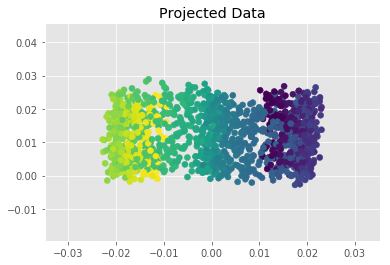

In [282]:
fig, ax = plt.subplots()

ax.scatter(embedding[:, 0], embedding[:, 1], c=color)
ax.set_title('Projected Data')
plt.show()

### Kernel Graph Embedding

In [196]:
# # Transform equation
# lap_sol = -1 * L

# # convert to linear problem
# A = K.T.dot(L).dot(K)
# B = K.T.dot(np.diag(degree)).dot(K)

In [270]:
%%time

eig_vals, eig_vecs = eigh_robust(
    K.T.dot(L.toarray()).dot(K), 
    K.T.dot(np.diag(degree)).dot(K), 
    eigvals=(0, n_components - 1))

CPU times: user 1.88 s, sys: 30.4 ms, total: 1.91 s
Wall time: 985 ms


In [271]:
eig_vecs = _deterministic_vector_sign_flip(eig_vecs)

embedding = np.dot(K, eig_vecs)

embedding = _deterministic_vector_sign_flip(embedding)


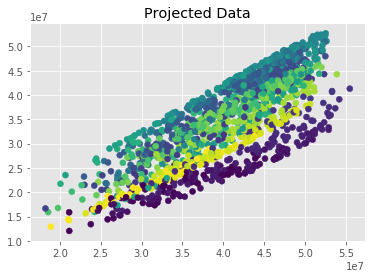

In [272]:
fig, ax = plt.subplots()

ax.scatter(embedding[:, 0], embedding[:, 1], c=color)
ax.set_title('Projected Data')
plt.show()